#### Helper Methode zum Rendern des Zustandes im Jupyter Notebook

In [1]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

def show_state(env, step=0, info=""):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id,step,info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

# CartPole

## Aufgabe 2

Löse das CartPole-v0 (https://gym.openai.com/envs/CartPole-v0/) Environment mittels des bereits bekannten Q-Learning. Beachte hierbei, dass es sich um einen continuous state-space handelt und dieser für den tabellelarischen Ansatz zuerst in einen discrete Space transformiert werden muss.

**Hinweis:** Für die Lösung müssen nicht alle zur Verfügung stehenden Eingabefeatures genutzt werden. 

### Übersicht über die vom Environment bereitgestellten Features und deren Wertebereiche

- x (Wagenposition) ∈ [-4.8, 4.8] / 1 Werte -> 0
- x’ (Wagengeschwindigkeit) ∈ [-3.4 10^38, 3.4 10^38] / 1 Werte -> 0
- theta (Neigungswinkel) ∈ [-0.42, 0.42] / 6 Werte -> 0...5
- theta’ (Winkelgeschwindigkeit) ∈ [-3.4 10^38, 3.4 10^38] / 12 Werte -> 0..11

In [2]:
%run ../setup.ipynb

In [3]:
import math

def discretize(env, buckets, obs):
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
    ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
    new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
    new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
    return tuple(new_obs)

In [4]:
from lib.statistics import plot

n_episodes = 1000
max_steps = 200

def interact_with_environment(env, agent, buckets, verbose=False):
    statistics = []
    
    if verbose:
        print('Startposition:')
        env.render()
    
    for episode in range(n_episodes):
        done = False
        total_reward = 0
        state = env.reset()
        state = discretize(env, buckets, state) # transform state
        

        for t in range(max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = discretize(env, buckets, next_state)
            
            agent.train((state, action, next_state, reward, done))
            
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        if verbose:
            print(f'episode: {episode}/{n_episodes}, score: {total_reward}, steps:{t}, e:{agent.epsilon:.2f}')
            env.render()
            
        statistics.append({
            'episode': episode,
            'score': total_reward,
            'steps': t
        })
        
    return statistics

### 2.1

Laut Schätzungen von Astonomen besteht das Universum aus etwa $10^{80}$ Atome. Ausgeschrieben sind das  100000000000000000000000000000000000000000000000000000000000000000000000000000000 Atome. Wie viele Zustände können in dem CartPole Environment auftreten, wenn die oben angegebenen Wertebereiche betrachtet werden? Welches Problem ergibt sich daraus für die Reinforcement Learning Aufgabe?

### 2.2
Implementiere in **agent.py** einen Agenten, der in der Lage ist das CartPole Environment zu lösen. Definiere dafür eine angemessene Diskretisierung der state-spaces.

In [5]:
import gym
env = gym.make('CartPole-v0')

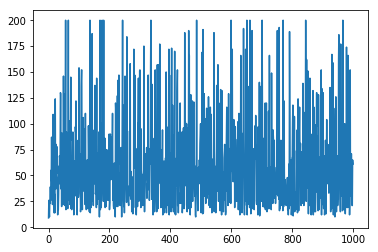

In [28]:
from agent import AdvancedQLearning

action_size = env.action_space.n

# Hyperparams
gamma = 1
epsilon = 1.0
epsilon_min = 0.01
alpha = 0.1
alpha_min = 0.01
buckets = (1, 1, 6, 13) # Define appropriate bucket sizes

agent = AdvancedQLearning(action_size=action_size, buckets=buckets, gamma=gamma, 
                          epsilon=epsilon, epsilon_min=epsilon_min, 
                          alpha=alpha, alpha_min=alpha_min)

statistics = interact_with_environment(env, agent, buckets, verbose=False)
plot(statistics)

### 2.3
Benutze GridSearch, um die Hyperparameter zu optimieren. Der `score` sollte bei `200` konvergieren.

In [7]:
from lib.hyperparameter_optimization import GridSearch
from functools import partial

grid_search = GridSearch(
    grid_params = {
        'gamma': [0.5, 1], # TODO
        'epsilon': [1, 0.01], # TODO
        'alpha': [1,0.1], # TODO
        'alpha_min': [0.1, 0.01], # TODO
        'epsilon_min': [0.1,0.01], # TODO
        'buckets': [(1,1,6,8),(1,1,6,15),(1,1,6,12),(1,1,3,6),(1,1,6,3)] # TODO
    },
    fixed_params = {
        'action_size': env.action_space.n
    },
    construct_env = partial(gym.make, 'CartPole-v0'),
    construct_agent = AdvancedQLearning,
    evaluation_func = interact_with_environment,
    grid_params_for_evaluation_func = ['buckets'],
    score_parameter = 'score'
)
grid_search.run()

INFO:lib.hyperparameter_optimization:About to evaluate 160 parameter sets.
INFO:lib.hyperparameter_optimization:Finished evaluating set 15 with score of 9.375.
INFO:lib.hyperparameter_optimization:Finished evaluating set 30 with score of 9.412.
INFO:lib.hyperparameter_optimization:Finished evaluating set 20 with score of 9.915.
INFO:lib.hyperparameter_optimization:Finished evaluating set 10 with score of 14.087.
INFO:lib.hyperparameter_optimization:Finished evaluating set 5 with score of 15.414.
INFO:lib.hyperparameter_optimization:Finished evaluating set 0 with score of 20.099.
INFO:lib.hyperparameter_optimization:Finished evaluating set 21 with score of 9.924.
INFO:lib.hyperparameter_optimization:Finished evaluating set 31 with score of 12.892.
INFO:lib.hyperparameter_optimization:Finished evaluating set 6 with score of 9.457.
INFO:lib.hyperparameter_optimization:Finished evaluating set 22 with score of 9.388.
INFO:lib.hyperparameter_optimization:Finished evaluating set 7 with score 